# **Employee Attrition** 👷‍♀️👷‍♂️

`Objective:` The key to success in any organization is attracting and retaining top talent. I’m an HR analyst at my company, and one of my tasks is to determine which factors keep employees at my company and which prompt others to leave. I need to know what factors I can change to prevent the loss of good people. Watson Analytics is going to help.

'Attrition', 'Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany'

In [73]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import deque, Counter
from matplotlib.patches import Patch, ConnectionPatch

In [74]:
df = pd.read_csv('dataset\WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [75]:
df_clean = df[['Attrition', 'Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany']]

In [76]:
df_clean.head()

,Attrition,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
0,Yes,Sales,Female,41,2,4,5993,6
1,No,Research & Development,Male,49,3,2,5130,10
2,Yes,Research & Development,Male,37,4,3,2090,0
3,No,Research & Development,Female,33,4,3,2909,8
4,No,Research & Development,Male,27,1,2,3468,2


In [77]:
def sampling(df, col, ratio=0.1):
    classes = np.unique(df[col])
    count = int(len(df) * ratio)
    indices = []
    for cls in classes:
        index = df[df[col] == cls].index.tolist()
        np.random.shuffle(index)
        indices.append(index[:count])
    return indices
        
indices = [index for index_list in sampling(df, 'Attrition', ratio=0.2) for index in index_list]
indices[:5]

[394, 962, 961, 579, 1026]

<div style="background-color:red; color:white; font-family:'Poppins'; font-size:40px; border-radius:10px; padding:30px; text-align:center;">1 | Exploratory Data Analysis </div>

In [78]:
df_clean = df_clean.loc[indices]
df_clean.shape 

(531, 8)

the data after sampling has `531` instances

<div style="background-color:white; color:red; font-family:'Poppins'; font-size:20px; border-radius:10px; padding:20px; ">Univariate Analysis </div>

In [79]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531 entries, 394 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Attrition                531 non-null    object
 1   Department               531 non-null    object
 2   Gender                   531 non-null    object
 3   Age                      531 non-null    int64 
 4   EnvironmentSatisfaction  531 non-null    int64 
 5   JobSatisfaction          531 non-null    int64 
 6   MonthlyIncome            531 non-null    int64 
 7   YearsAtCompany           531 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 37.3+ KB


the dataset is dominated with numeric cols

In [80]:
numeric_data = df_clean.select_dtypes(include='number')
object_data = df_clean.select_dtypes(include='object')
print(f'Num cols: {len(numeric_data.columns)}')
print(f'Obj cols: {len(object_data.columns)}')

Num cols: 5
Obj cols: 3


In [81]:
numeric_desc = df_clean.describe(include='number').T 
numeric_desc['nunique'] = [df_clean[col].nunique() for col in numeric_data.columns]
numeric_desc

,count,mean,std,min,25%,50%,75%,max,nunique
Age,531.0,35.557439,9.449269,18.0,29.0,34.0,41.0,60.0,42
EnvironmentSatisfaction,531.0,2.610169,1.136284,1.0,2.0,3.0,4.0,4.0,4
JobSatisfaction,531.0,2.649718,1.097895,1.0,2.0,3.0,4.0,4.0,4
MonthlyIncome,531.0,5895.851224,4378.140930,1009.0,2685.0,4505.0,7429.0,19999.0,514
YearsAtCompany,531.0,6.248588,6.053720,0.0,2.0,5.0,9.0,40.0,31


`environment` and `job` satisfaction has `small amount` of unique val meaning they are discrete nmber, they are range between 1 to 4

In [82]:
object_desc = df_clean.describe(include='object').T 
object_desc['unique'] = [df_clean[col].unique() for col in object_data.columns]
object_desc

,count,unique,top,freq
Attrition,531,"[No, Yes]",No,294
Department,531,"[Research & Development, Human Resources, Sales]",Research & Development,332
Gender,531,"[Female, Male]",Male,331


`department` has 3 unique vals with most of the freq is `RnD` (dominating the dataset)

<div style="background-color:white; color:red; font-family:'Poppins'; font-size:20px; border-radius:10px; padding:20px; ">Data Inconsistecies Analysis </div>

In [83]:
df_clean.isna().sum()

Attrition                  0
Department                 0
Gender                     0
Age                        0
EnvironmentSatisfaction    0
JobSatisfaction            0
MonthlyIncome              0
YearsAtCompany             0
dtype: int64

In [84]:
df_clean.duplicated().sum()

0

great no duplicates and null vals

In [85]:
plt.rcParams['figure.figsize'] = (15, 10)

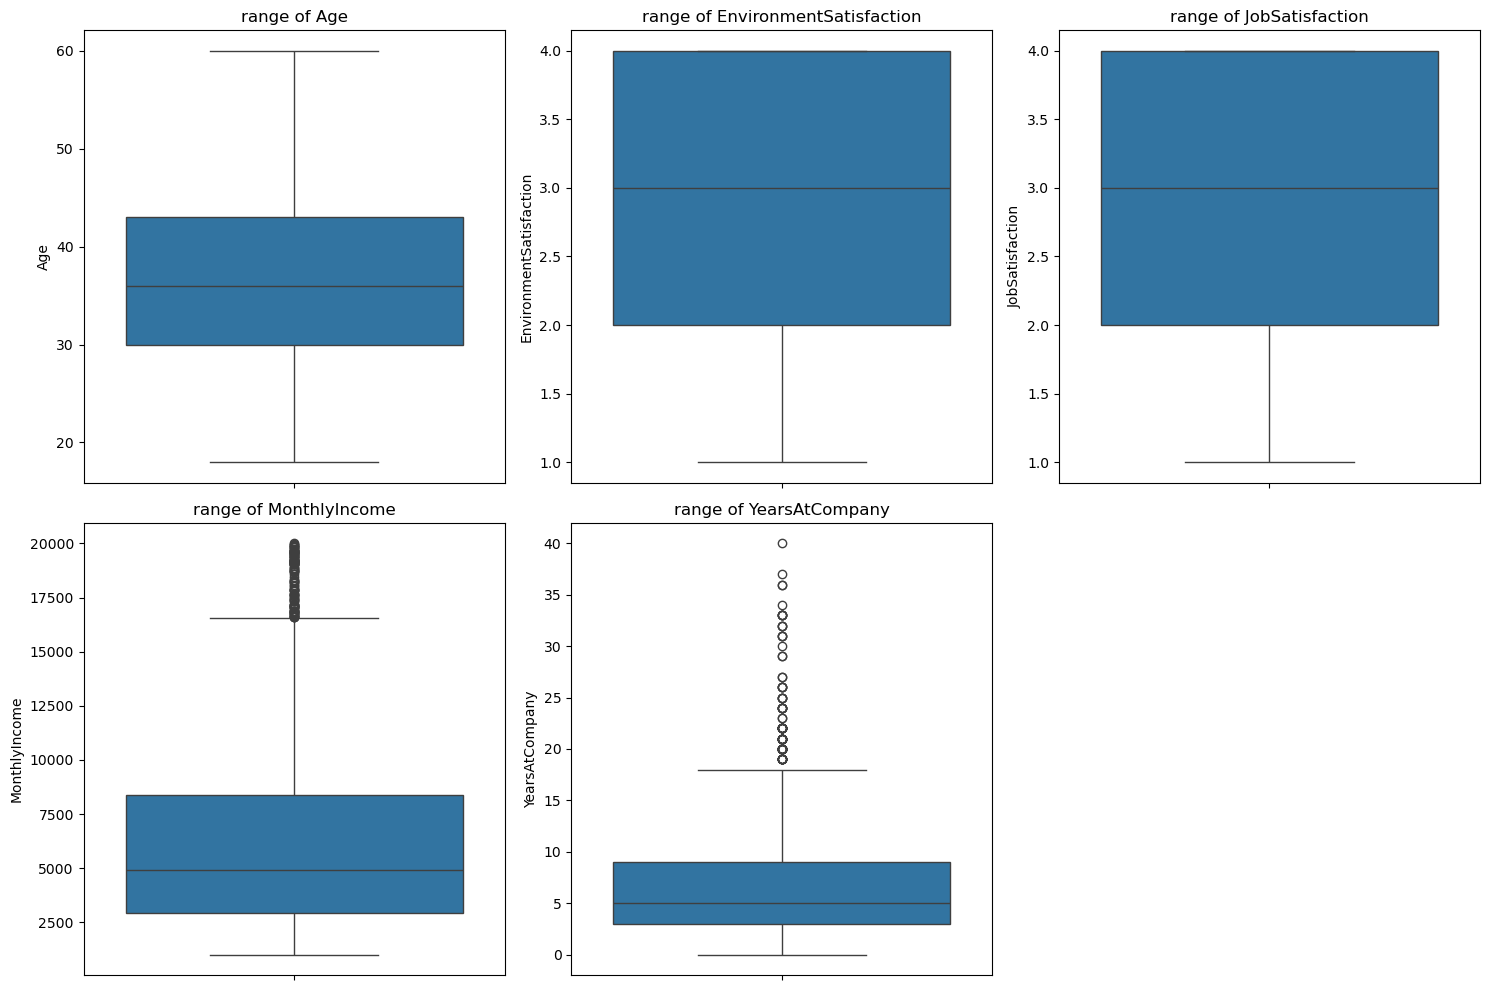

In [86]:
for i, col in enumerate(numeric_data.columns):
    plt.subplot(2, 3, i+1)
    plt.title(f'range of {col}')
    sns.boxplot(df[col])
plt.tight_layout()
plt.show()

- `monthly income `and `years at company` has outliers, meaning 
- there are data with more `income` than the avg range and 
- people who are really `loyal` to the company

In [87]:
def zscore(data):
    z = (data - data.mean()) / data.std()
    outliers = z[(z < -3) | (z > 3)]
    return outliers

for i, col in enumerate(numeric_data.columns):
    outliers = zscore(df[col])
    print(f'{len(outliers)} in {col}')

0 in Age
0 in EnvironmentSatisfaction
0 in JobSatisfaction
0 in MonthlyIncome
25 in YearsAtCompany


however using zscores, the `outliers` detected is **not as much as** the boxplot who uses `IQR`, since decision tree is `robust` to outliers, we're going to use zscore instead

In [88]:
df_clean.var(numeric_only=True)

Age                        8.928868e+01
EnvironmentSatisfaction    1.291142e+00
JobSatisfaction            1.205373e+00
MonthlyIncome              1.916812e+07
YearsAtCompany             3.664752e+01
dtype: float64

monthly income has a huge range of data to the mean 

In [89]:
df_clean.skew(numeric_only=True)

Age                        0.522365
EnvironmentSatisfaction   -0.200421
JobSatisfaction           -0.243074
MonthlyIncome              1.552103
YearsAtCompany             2.013825
dtype: float64

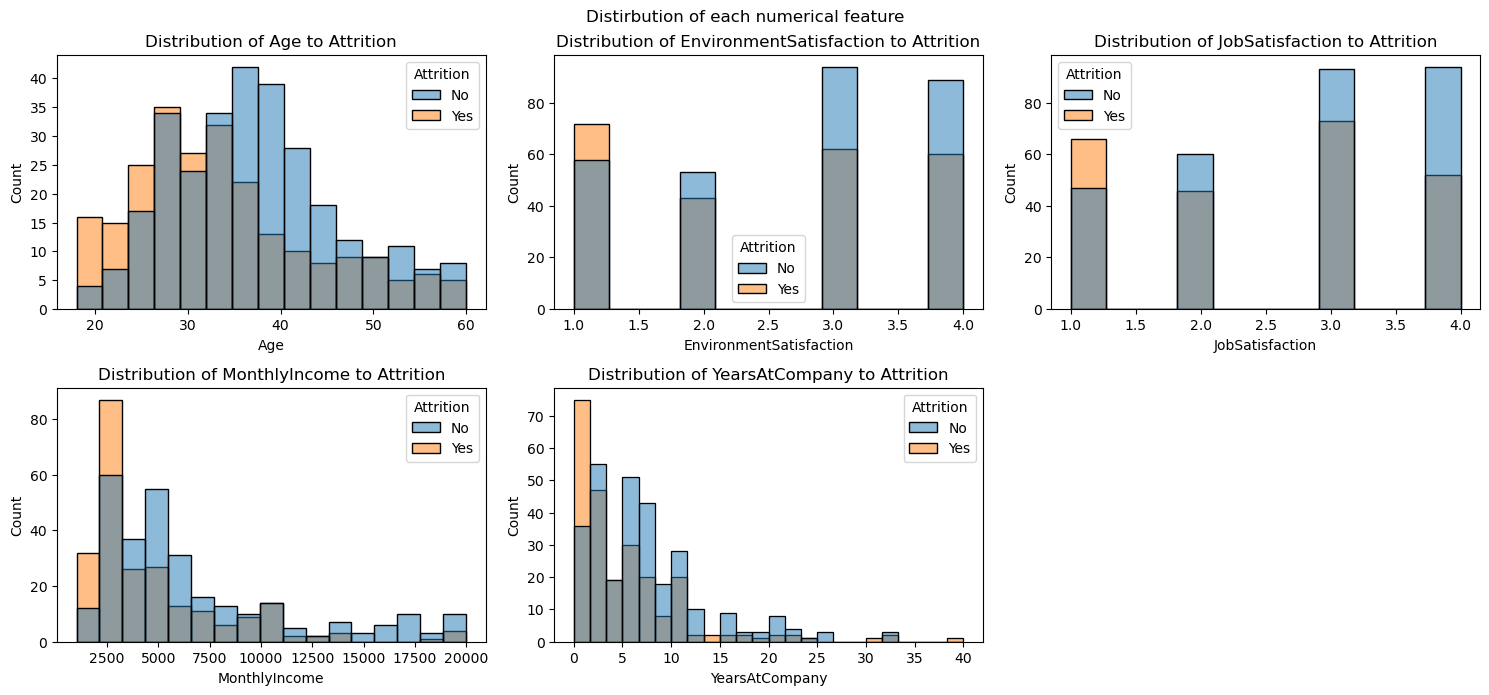

In [90]:
for i, col in enumerate(numeric_data):
    plt.subplot(3, 3, i+1)
    sns.histplot(x=numeric_data[col], hue=df_clean['Attrition'])
    plt.title(f"Distribution of {col} to Attrition")

plt.suptitle(t="Distirbution of each numerical feature", fontsize=12)
plt.tight_layout()
plt.show()


## **Insight of Distribution Histogram Plot 🔬**
- `YearsAtCompany` and `MontlyIncome` have same pattern that left skew, it mean there dominated employee with low `YearsAtCompany` have low `MontlyIncome`
- while Age Attrtion Yes is dominated in age below 35

the skewness across the dataset is still considerable

<div style="background-color:white; color:red; font-family:'Poppins'; font-size:20px; border-radius:10px; padding:20px; ">Bivariate Analysis </div>

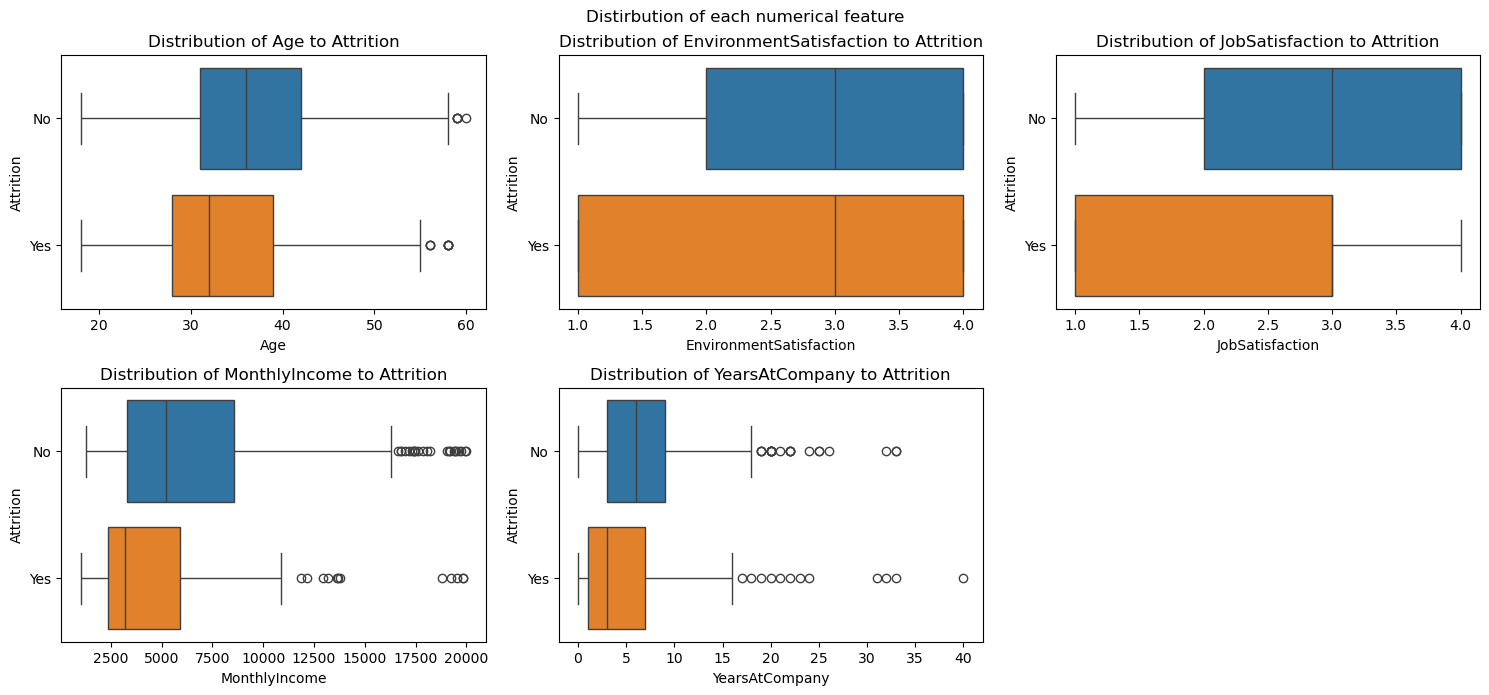

In [91]:
for i, col in enumerate(numeric_data):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_clean['Attrition'], x=numeric_data[col], hue=df_clean['Attrition'])
    plt.title(f"Distribution of {col} to Attrition")

plt.suptitle(t="Distirbution of each numerical feature", fontsize=12)
plt.tight_layout()
plt.show()


## **Insight of Numerical Columns 🔬**
- in columns of `Age`, `MonthlyIncome` and `YearsCompony` have same pattern, the Attrition of Yes is dominiated in low `Age`, `MonthlyIncome` and `YearsCompony` while it not significant
- while `JobSatisfication` have characteristic of very diverse, the lower employee `JobSatisfacation`, emloye Yess for attrition, and high the statification emloyee no for Attrition
- but on `EnvirimentSatstication` it quite normal distribute, it mean `EnvirimentSatstication` not significant effect to the emloyee Attrition


In [92]:
crosstab1 = pd.crosstab( object_data['Attrition'],object_data['Department'])

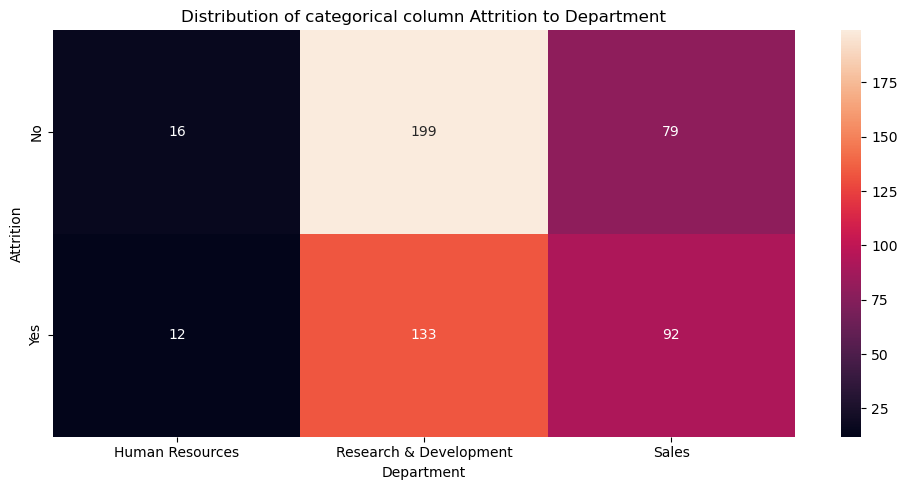

In [93]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of categorical column Attrition to Department")
sns.heatmap(crosstab1, annot=True, fmt="d")
plt.tight_layout()

### **Important Insight of Categorical Attrition to Department 🔬**
- Department human resource have equl Attrition 
- while R&D Deoartment dominated contine work or No Attrition, this effect because the R7D need a long time research
- and sales is dominated not continue it might be because the have short time contract trend of depanrtment


In [94]:
crosstab2 = pd.crosstab( object_data['Attrition'],object_data['Gender'])

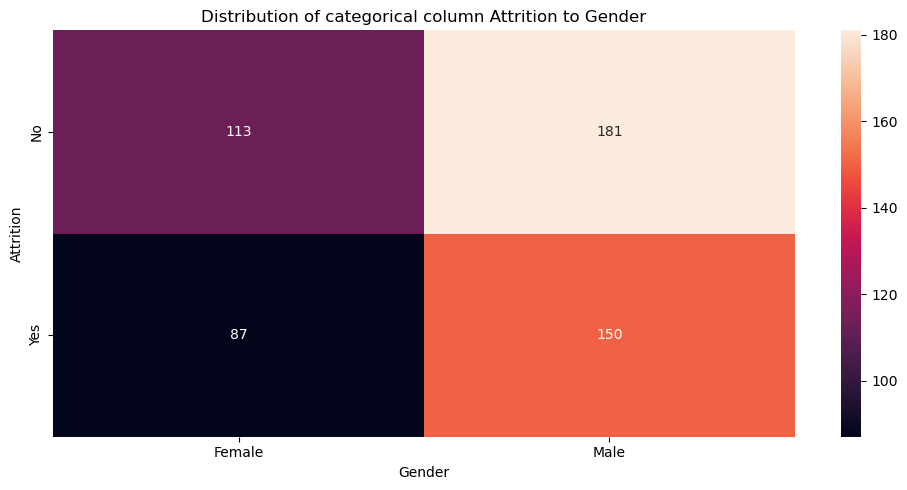

In [95]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of categorical column Attrition to Gender")
sns.heatmap(crosstab2, annot=True,  fmt="d")
plt.tight_layout()

### **Important Insight of Categorical Attrition to Gender 🔬**
- Most of female & Male continue working but not highly significant different

## **Conclusion and Key Insight**

Characteristic of Attrition Yes:
- Low Age, Low Mothly Income, Low Years At Company and Low Job Satification
- Male or female not effectting to attrition
- Department R&D is most Atrtion Yes, and Sales is opposite of r&D


## Feature Encoding

In [96]:
def encoding(df, cols):
    for col in cols:
        df[col] = df[col].astype('category').cat.codes
    return df 

df_clean = encoding(df_clean, object_data.columns.tolist())
df_clean.head()

,Attrition,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
394,0,1,0,31,2,1,4306,13
962,0,0,1,51,3,2,14026,33
961,0,1,1,35,3,3,4249,9
579,0,1,0,34,3,1,4381,6
1026,0,2,1,32,4,4,9204,4


encoding is a must so the model can detect the categorical as well, because we're going to use threshold and binary split

## Multivariate Analaysis

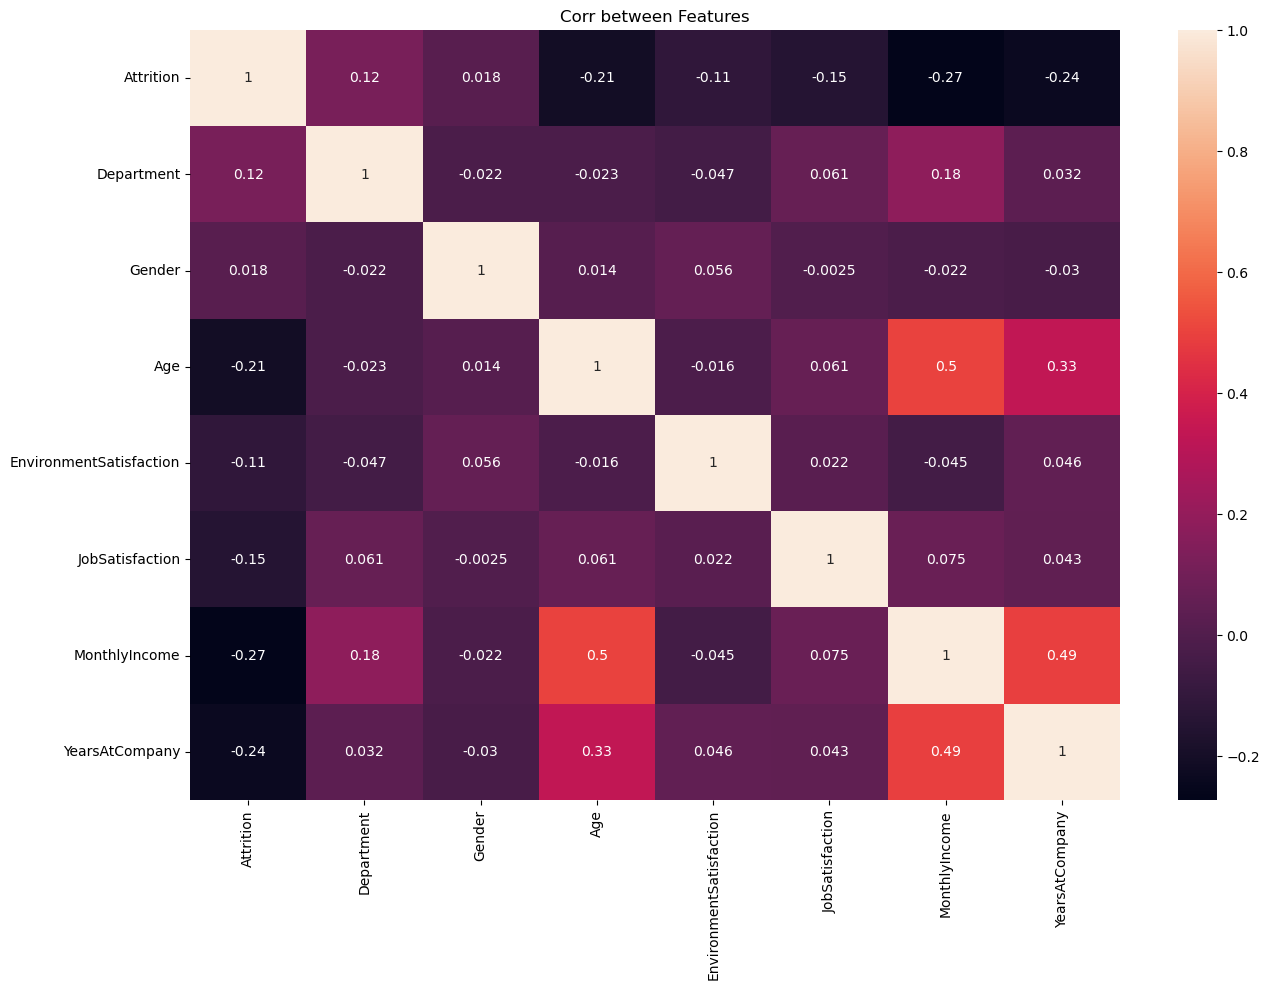

In [97]:
sns.heatmap(df_clean.corr(method='spearman'), annot=True)
plt.title('Corr between Features')
plt.show()

- `monthly income` has a ***moderate*** corr (not so strong) with Age and years at company  
- the older the higher salary, the longer you stay the higfher salary

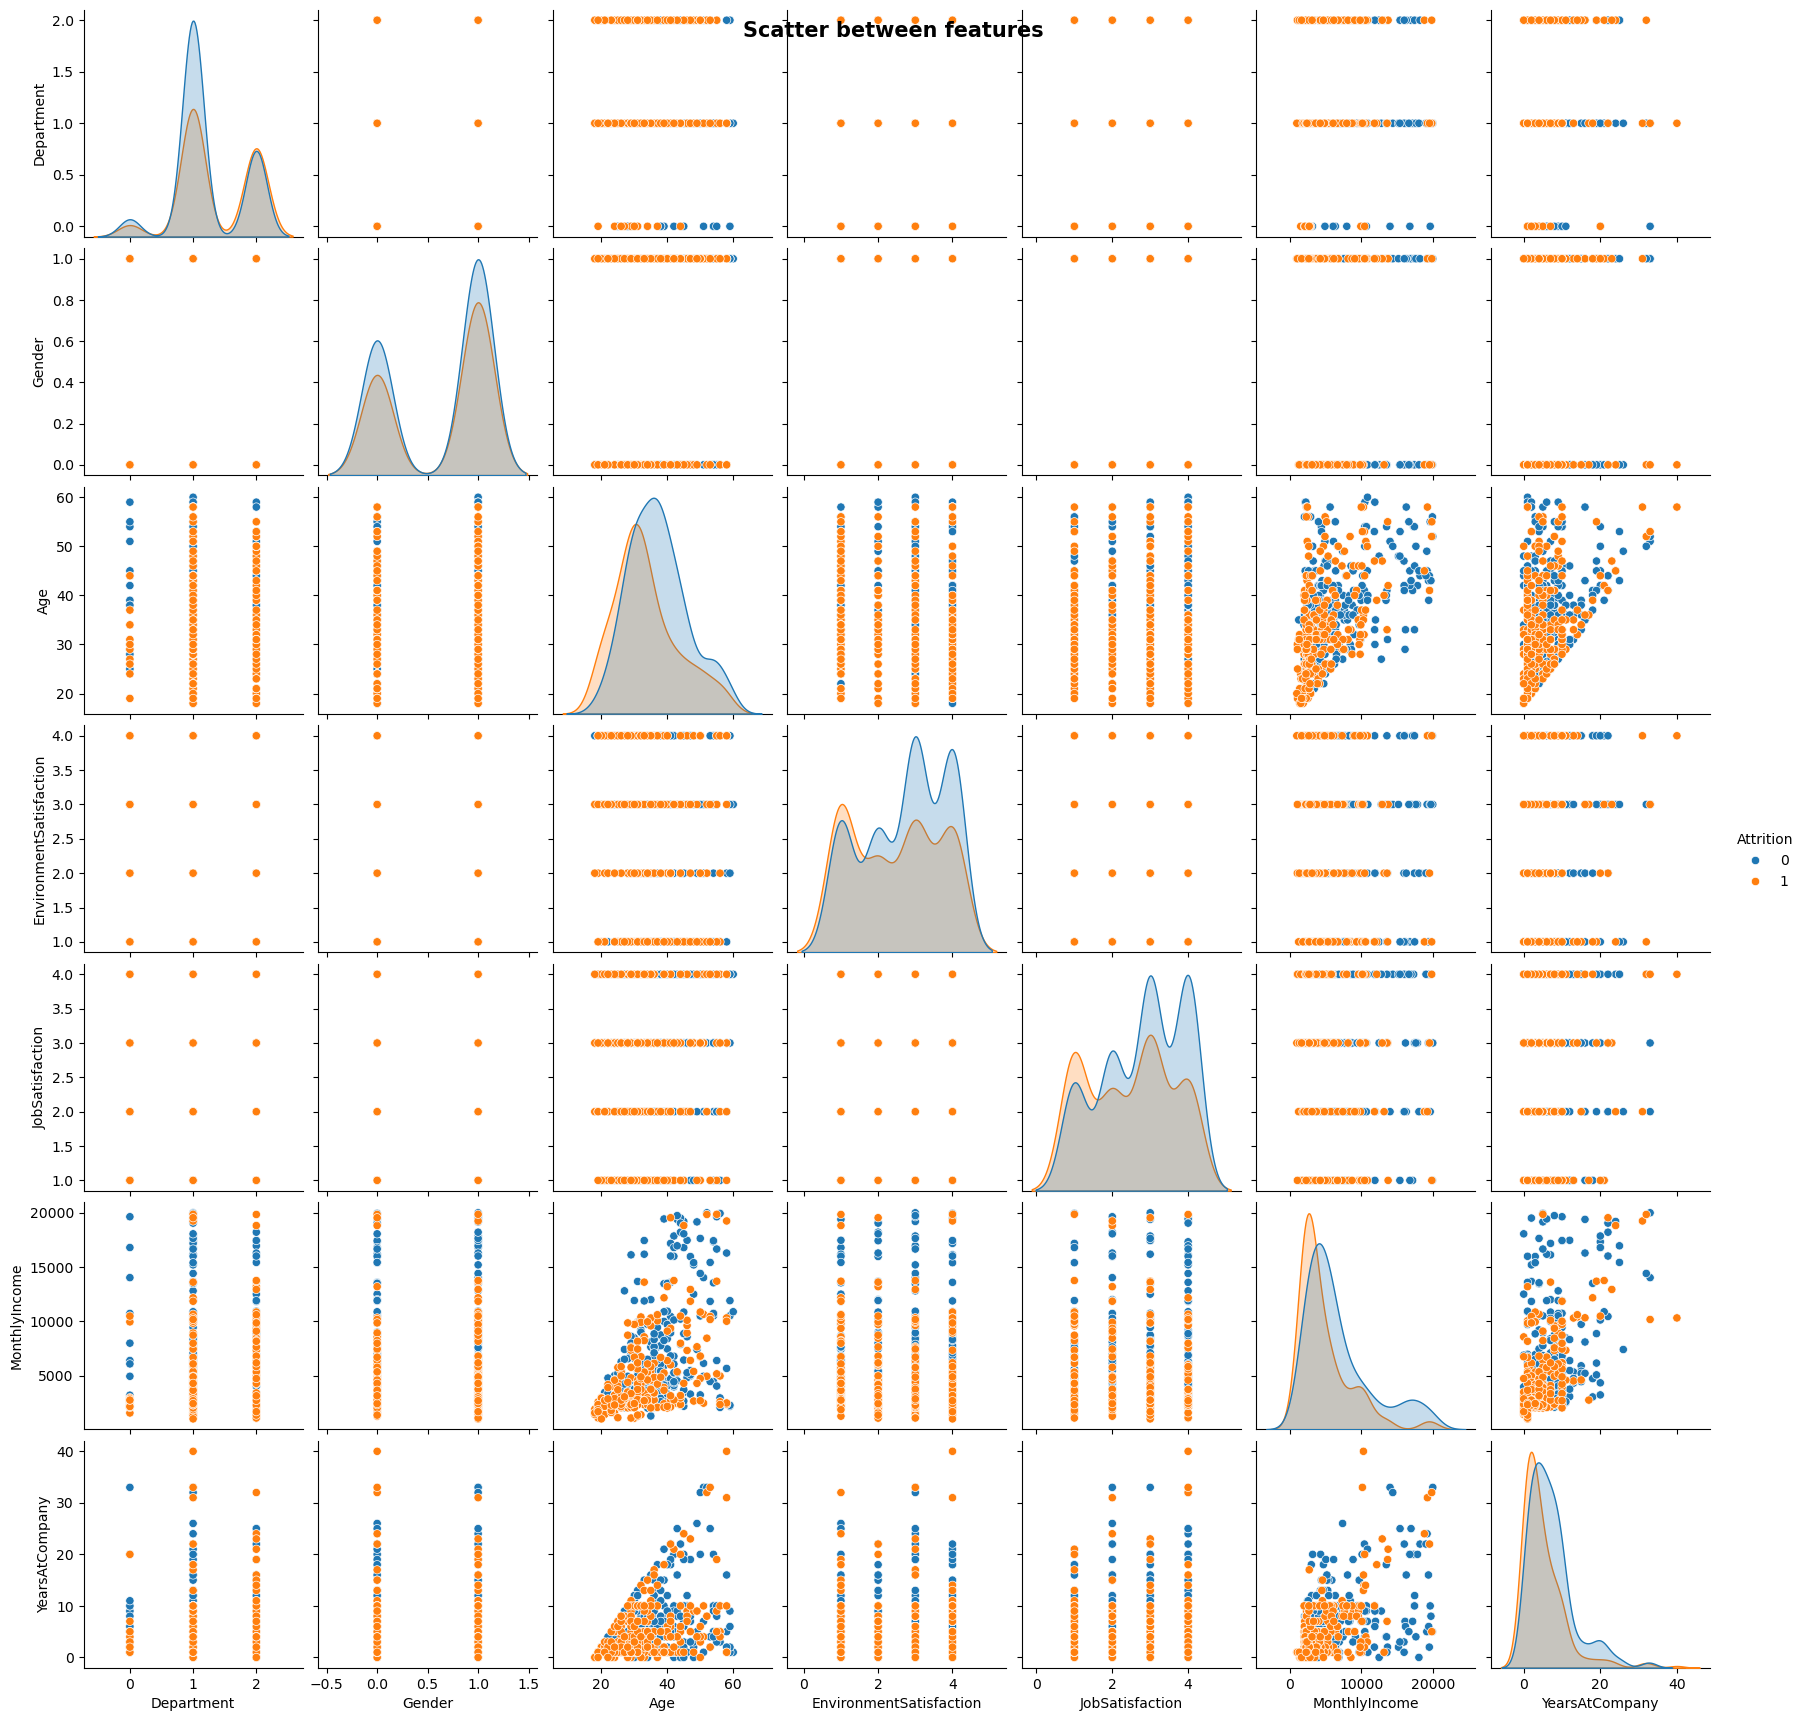

In [98]:
sns.pairplot(df_clean, hue='Attrition')
plt.suptitle('Scatter between features', size=15, weight='bold')
plt.show()

the two classes are `overlapped`, but attritio one is more consistent in range

## Feature Selection

In [99]:
bins = int(np.log(len(df_clean)) + 1)
print(f'How many group can we have: {bins}')

How many group can we have: 7


In [100]:
def mutual_information(crosstab):
    observed = np.array(crosstab.iloc[:-1, :-1])
    ratio = observed / np.sum(observed)
    Px = np.sum(ratio, axis=1, keepdims=True)
    Py = np.sum(ratio, axis=0, keepdims=True)
    nonzero = ratio > 0
    MI = np.sum(ratio[nonzero] * np.log(ratio[nonzero] / (Px @ Py)[nonzero]))
    return MI 

for col in numeric_data.columns:
    X = np.array(df_clean[col])
    X = np.digitize(X, bins=np.linspace(X.min(), X.max(), bins))
    X = pd.DataFrame(X.T)
    crosstab = pd.crosstab(X[0], df_clean['Attrition'], margins=True)
    MI = mutual_information(crosstab)
    print(f'{col}: {MI}')

for col in object_data.columns:
    crosstab = pd.crosstab(df_clean[col], df_clean['Attrition'], margins=True)
    MI = mutual_information(crosstab)
    print(f'{col}: {MI}')

Age: 0.006515217776576963
EnvironmentSatisfaction: 0.002181950765268353
JobSatisfaction: 0.01878600398027261
MonthlyIncome: 0.017359731583278283
YearsAtCompany: 0.014889505885438501
Attrition: 0.6873746294404351
Department: 0.008136058504900939
Gender: 0.00015698546977770816


`Attrition` and itself has **0.68** MI, meaning its the max, followed by `age` and `monthly income`

## Cross Validation 

In [101]:
def accuracy_score(y_test, y_pred):
    return np.mean(y_test == y_pred) * 100

def cross_validation(X, y, model, k=5, pruning=False, alpha=0.0):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    fold_size = n_samples // k
    accuracies = []

    for i in range(k):
        test_start = i * fold_size
        test_end = test_start + fold_size if i < k -1 else n_samples 
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train.reshape(-1, 1))

        if pruning=='rep':
            model.reduced_error_pruning(X_test, y_test, model.root)
        elif pruning=='ccp':
            model.cost_complexity_pruning(alpha)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    data = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'y_pred': y_pred, 'test_indices':test_indices, 'train_indices':train_indices,
        'accuracies':accuracies
    }

    return data 

## Modelling

In [102]:
from collections import Counter

In [103]:
attrition = df_clean['Attrition']
df_clean = df_clean.drop('Attrition', axis=1)
df_clean['Attrition'] = attrition
df_clean.head()

,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany,Attrition
394,1,0,31,2,1,4306,13,0
962,0,1,51,3,2,14026,33,0
961,1,1,35,3,3,4249,9,0
579,1,0,34,3,1,4381,6,0
1026,2,1,32,4,4,9204,4,0


In [104]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None, sample=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left 
        self.right = right
        self.info_gain = info_gain
        self.value = value 
        self.sample = sample 

In [105]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=3, min_sample_split=2, min_sample_leaf=1, features=None, mode='gini'):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.min_sample_leaf = min_sample_leaf
        self.features = features
        self.mode = mode 

        self.root = None
        self.feature_importance = None 

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape 

        features = np.arange(n_features)
        if self.features != None:
            features = self.features

        if n_samples>=self.min_sample_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, n_samples, features)

            if best_split['info_gain']>0 and len(best_split['dataset_left'])>=self.min_sample_leaf and len(best_split['dataset_right'])>=self.min_sample_leaf:
                feature_index = best_split['feature_index']

                self.feature_importance[0][feature_index] += best_split['info_gain']
                self.feature_importance[1][feature_index] += 1

                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)
                return Node(
                    feature_index=feature_index, threshold=best_split['threshold'], left=left_subtree, right=right_subtree, info_gain=best_split['info_gain'], sample=Y
                )
        leaf_value = self.calc_leaf_value(Y)
        return Node(value=leaf_value, sample=Y)
    
    def get_best_split(self, dataset, n_samples, features):
        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in features:
            possible_thresholds = np.unique(dataset[:, feature_index])
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)

                    if curr_info_gain > max_info_gain:
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'dataset_left': dataset_left,
                            'dataset_right': dataset_right,
                            'info_gain': curr_info_gain,
                        }
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def calc_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    


    """INFORMATION GAIN"""
    def information_gain(self, parent, l_child, r_child, mode):
        l_weight = len(l_child) / len(parent)
        r_weight = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini(parent) - (l_weight*self.gini(l_child) + r_weight*self.gini(r_child))
        elif mode == 'entropy':
            gain = self.entropy(parent) - (l_weight*self.entropy(l_child) + r_weight*self.entropy(r_child))
        return gain 
    
    def entropy(self, y):
        classes = np.unique(y)
        entropy = 0
        for cls in classes:
            p_cls = len(y[y==cls]) / len(y)
            entropy += -p_cls * np.log(p_cls)
        return entropy
    
    def gini(self, y):
        classes = np.unique(y)
        gini = 0
        for cls in classes:
            p_cls = len(y[y==cls]) / len(y)
            gini += p_cls ** 2
        return 1-gini
    


    """POST PRUNING"""
    def reduced_error_pruning(self, X_test, y_test, tree):
        if tree.left and tree.right:
            self.reduced_error_pruning(X_test, y_test, tree.left)
            self.reduced_error_pruning(X_test, y_test, tree.right)

            if tree.left.value != None and tree.right.value != None:
                accuracy_before = np.mean(self.predict(X_test) == y_test)
                tree.value = self.calc_leaf_value(y_test)
                accuracy_pruned = np.mean(self.predict(X_test) == y_test)

                if accuracy_pruned > accuracy_before:
                    tree.left = None
                    tree.right = None 
                else:
                    tree.value = None

    def cost_complexity_pruning(self, alpha=0.01, tree=None):
        if tree is None:
            tree = self.root 

        if tree.left and tree.right:
            self.cost_complexity_pruning(alpha, tree.left)
            self.cost_complexity_pruning(alpha, tree.right)

            left_cost = self._calc_subtree_cost(tree.left)
            right_cost = self._calc_subtree_cost(tree.right)

            if (left_cost + right_cost - 1) * alpha >= tree.info_gain:
                tree.value = self.calc_leaf_value([leaf.value for leaf in self._get_leaves(tree)])
                tree.left = tree.right = None 
        return tree 

    def _get_leaves(self, tree=None):
        if tree.value is not None:
            return [tree]
        return self._get_leaves(tree.left) + self._get_leaves(tree.right)
    
    def _calc_subtree_cost(self, tree=None):
        if tree is None:
            return 0
        
        if tree.value is not None:
            y = np.array(tree.sample)
            if self.mode == 'gini':
                return self.gini(y)
            else:
                return self.entropy(y)

        left_cost = self._calc_subtree_cost(tree.left)
        right_cost = self._calc_subtree_cost(tree.right)
        return left_cost + right_cost + 1



    """FIT AND PREDICT"""
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.feature_importance = np.zeros([2, X.shape[1]])
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions
    
    def make_predictions(self, x, tree=None):
        if tree.value is not None:
            return tree.value 
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)
        

    
    """LEAF INFO"""
    def print_tree(self, tree=None, depth=0):
        if tree is None:
            tree = self.root 

        if tree.value is not None:
            print(f'{"  " * depth} leaf: class {tree.value} | {dict(Counter(tree.sample))} | level: {depth}')
            return 
        
        print(f'{"  " * depth} Feature {tree.feature_index}: <= {tree.threshold} |  {dict(Counter(tree.sample))} | info_gain: {tree.info_gain} | level: {depth}')
        self.print_tree(tree.left, depth + 1)
        self.print_tree(tree.right, depth + 1)

    def get_leaf_all_info(self, tree=None, node_id=0, leaf_info=None):
        if leaf_info is None:
            leaf_info = {}

        if tree is None:
            tree = self.root 

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count)) for k, v in count.items()}
            leaf_info[node_id] = ratio
            return leaf_info
        
        self.get_leaf_all_info(tree.left, node_id * 2 + 1, leaf_info)
        self.get_leaf_all_info(tree.right, node_id * 2 + 2, leaf_info)
        return leaf_info
    
    def get_leaf_info(self, x, tree=None, node_id=0):
        if tree is None:
            tree = self.root

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count)) for k, v in count.items()}
            return node_id, ratio
        
        print(tree.feature_index)
        feature_val = x[tree.feature_index]
        print(feature_val)
        if feature_val <= tree.threshold:
            return self.get_leaf_info(x, tree.left, node_id * 2 + 1)
        else:
            return self.get_leaf_info(x, tree.right, node_id * 2 + 2)


## `Scenario 1:` Minimum Limitations

In [106]:
df_clean = df_clean.reset_index(drop=True)

In [107]:
X = df_clean.iloc[:, :-1].values
Y = df_clean.iloc[:, -1].values

In [108]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=0, features=None, mode='gini')
data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)
test = len(data['test_indices']) / len(df_clean) * 100
train = len(data['train_indices']) / len(df_clean) * 100
print(f'Test size: {round(test)}%')
print(f'Train size: {round(train)}%')

Test size: 20%
Train size: 80%


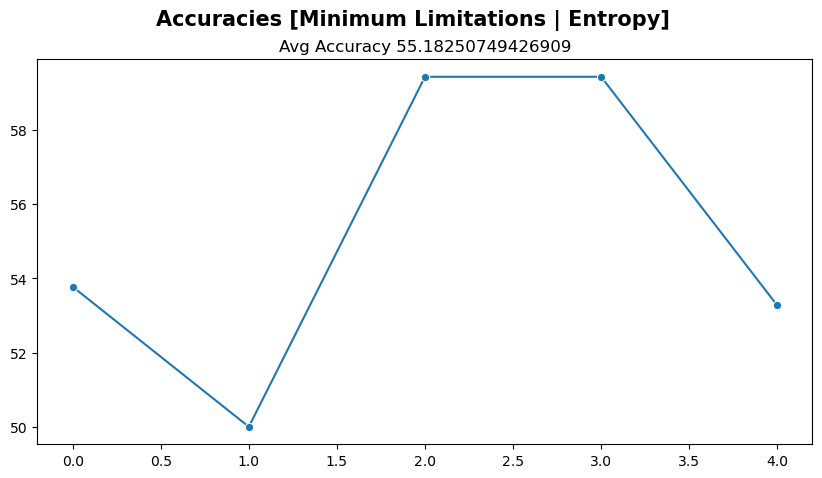

In [109]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='entropy')
data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)
avg_accuracy = np.mean(data['accuracies'])

plt.figure(figsize=(10, 5))
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracies [Minimum Limitations | Entropy]', size=15, weight='bold')
plt.title(f'Avg Accuracy {avg_accuracy}')
plt.show()

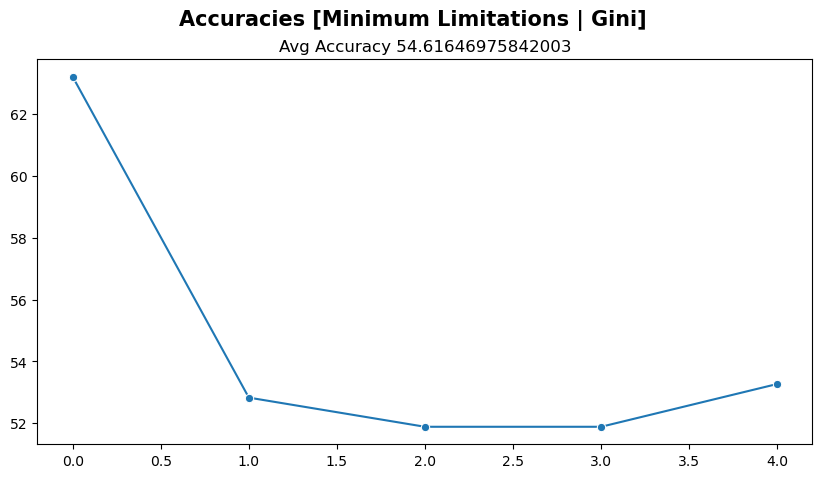

In [110]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)
avg_accuracy = np.mean(data['accuracies'])

plt.figure(figsize=(10, 5))
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracies [Minimum Limitations | Gini]', size=15, weight='bold')
plt.title(f'Avg Accuracy {avg_accuracy}')
plt.show()

In [111]:
df_clean['Attrition'].value_counts()

Attrition
0    294
1    237
Name: count, dtype: int64

`entropy` performs better because the class dist is quite even

In [112]:
feature_importance = pd.DataFrame([model.feature_importance[0], model.feature_importance[1], df_clean.columns.tolist()[:-1]]).T
feature_importance.columns = ['info_gain', 'count', 'feature_name']
feature_importance

,info_gain,count,feature_name
0,0.939921,6.0,Department
1,2.623005,10.0,Gender
2,9.481841,44.0,Age
3,2.285556,11.0,EnvironmentSatisfaction
4,1.745007,10.0,JobSatisfaction
5,4.612266,36.0,MonthlyIncome
6,1.775904,13.0,YearsAtCompany


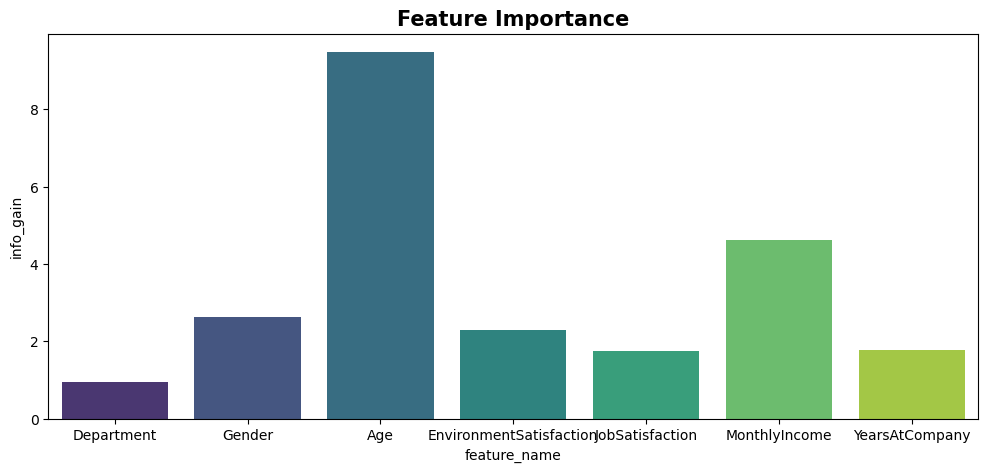

In [113]:
plt.figure(figsize=(12, 5))
sns.barplot(feature_importance, y='info_gain', x='feature_name', hue='feature_name', palette='viridis')
plt.title('Feature Importance', size=15, weight='bold')
plt.show()

In [114]:
model.print_tree()

 Feature 5: <= 2800 |  {1: 192, 0: 232} | info_gain: 0.0400716467072359 | level: 0
   Feature 6: <= 1 |  {1: 85, 0: 42} | info_gain: 0.026561361840672537 | level: 1
     Feature 2: <= 43 |  {1: 42, 0: 10} | info_gain: 0.027553033047538533 | level: 2
       Feature 5: <= 1420 |  {1: 41, 0: 8} | info_gain: 0.011995002082465678 | level: 3
         leaf: class 1 | {1: 9} | level: 4
         Feature 5: <= 1514 |  {1: 32, 0: 8} | info_gain: 0.03282051282051257 | level: 4
           leaf: class 0 | {0: 1} | level: 5
           Feature 2: <= 23 |  {1: 32, 0: 7} | info_gain: 0.01591058514135446 | level: 5
             Feature 4: <= 3 |  {1: 14, 0: 1} | info_gain: 0.035555555555555465 | level: 6
               leaf: class 1 | {1: 12} | level: 7
               Feature 0: <= 1 |  {0: 1, 1: 2} | info_gain: 0.1111111111111111 | level: 7
                 Feature 2: <= 18 |  {0: 1, 1: 1} | info_gain: 0.5 | level: 8
                   leaf: class 0 | {0: 1} | level: 9
                   leaf: class 1 |

`age` and `monthly` income indeed become the most used in decision nodes

In [115]:
model.get_leaf_all_info()

{15: {1: 9},
 33: {0: 1},
 139: {1: 12},
 563: {0: 1},
 564: {1: 1},
 282: {1: 1},
 283: {0: 2},
 569: {1: 2},
 570: {0: 1},
 285: {0: 1},
 1147: {0: 1},
 2297: {1: 7},
 4597: {0: 1},
 4598: {1: 1},
 574: {1: 8},
 17: {0: 2},
 18: {1: 1},
 79: {1: 8},
 80: {0: 1},
 163: {0: 5},
 164: {1: 1},
 1327: {1: 3},
 2657: {0: 6},
 10635: {1: 4},
 21273: {1: 1},
 21274: {0: 2},
 5318: {0: 4},
 1329: {0: 1},
 5323: {1: 3},
 21299: {0: 1},
 21300: {1: 3},
 21301: {1: 1},
 21302: {0: 2},
 2662: {1: 6},
 665: {1: 1},
 1333: {0: 6},
 2669: {1: 1},
 2670: {0: 1},
 166: {1: 5},
 20: {0: 3},
 10: {1: 6},
 95: {0: 1},
 193: {1: 5},
 389: {0: 1},
 1563: {1: 4},
 6259: {1: 1},
 6260: {0: 2},
 3130: {1: 3},
 782: {0: 1},
 97: {0: 3},
 197: {1: 2},
 198: {0: 2},
 49: {0: 7},
 101: {1: 2},
 823: {1: 2},
 1649: {1: 1},
 1650: {0: 3},
 825: {0: 11},
 1653: {1: 1},
 3309: {0: 3},
 6621: {0: 1},
 6622: {1: 1},
 827: {1: 1},
 1657: {0: 3},
 1658: {1: 1},
 414: {1: 3},
 831: {0: 1},
 832: {1: 1},
 416: {0: 4},
 417

- this is a huge tree, the leaves reached around hundreds K, 
- some leave has only `one sample`, 
- our model has become `overfit`, 
- rather than learning its approach is more of memorized really specific patterns

In [116]:
key_0 = len([val.get(0) for val in model.get_leaf_all_info().values() if val.get(0) != None])
key_1 = len([val.get(1) for val in model.get_leaf_all_info().values() if val.get(1) != None])
print(f'Total leaves with class 0: {key_0}')
print(f'Total leaves with class 1: {key_1}')

Total leaves with class 0: 65
Total leaves with class 1: 66


In [117]:
def zscore(data):
    z = (data - data.mean()) / data.std()
    outliers = z[(z < -3) | (z > 3)]
    return outliers

df_clean_outliers = df_clean.copy()
for i, col in enumerate(numeric_data.columns):
    outliers = zscore(df_clean_outliers[col])
    print(f'{len(outliers)} in {col} before')
    median = df[col].median()
    indices = outliers.index.tolist()
    df_clean_outliers.loc[indices, col] = median
    outliers = zscore(df_clean_outliers[col])
    print(f'{len(outliers)} in {col} after')

X = df_clean_outliers.iloc[:, :-1].values
Y = df_clean_outliers.iloc[:, -1].values

0 in Age before
0 in Age after
0 in EnvironmentSatisfaction before
0 in EnvironmentSatisfaction after
0 in JobSatisfaction before
0 in JobSatisfaction after
14 in MonthlyIncome before
13 in MonthlyIncome after
10 in YearsAtCompany before
10 in YearsAtCompany after


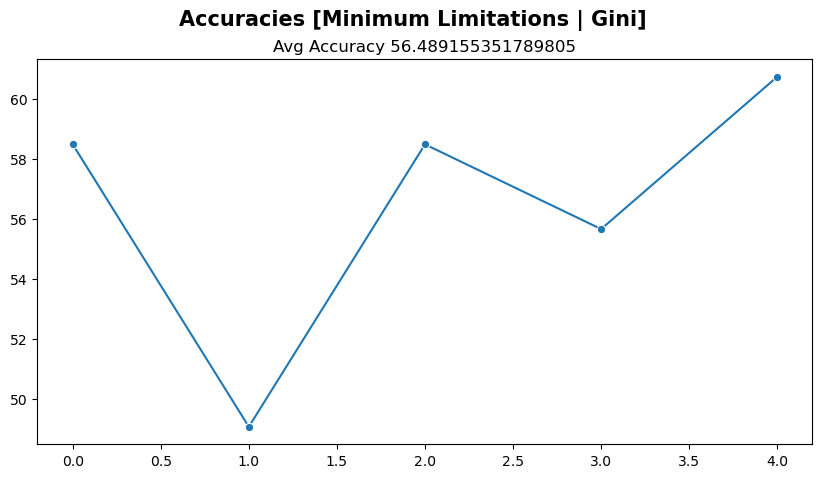

In [118]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)
avg_accuracy = np.mean(data['accuracies'])

plt.figure(figsize=(10, 5))
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracies [Minimum Limitations | Gini]', size=15, weight='bold')
plt.title(f'Avg Accuracy {avg_accuracy}')
plt.show()

## `Scenario 2:` Pre Pruning

In [119]:
from itertools import product

max_depth = [3, 10]
min_sample_splits = [6, 10]
min_sample_leaves = [1, 3]
features = [None, [2, 5]]
modes = ['gini', 'entropy']

param_combinitions = list(product(max_depth, min_sample_splits, min_sample_leaves, features, modes))
print(f'Total combo: {len(param_combinitions)}')

Total combo: 32


In [120]:
accuracies = []
for param in param_combinitions:
    model = DecisionTreeClassifier(max_depth=param[0], min_sample_split=param[1], min_sample_leaf=param[2], features=param[3], mode=param[4])
    data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)
    avg_accuracy = np.mean(data['accuracies'])
    accuracies.append(avg_accuracy)

In [121]:
indices = np.argsort(accuracies)[::-1]
top_3 = np.array(accuracies)[indices[:3]]
least_3 = np.array(accuracies)[indices[-3:]]
param_top_3 = [param_combinitions[i] for i in indices[:3]]
param_least_3 = [param_combinitions[i] for i in indices[-3:]]

In [122]:
print(f'Top 3: {param_top_3}')
print(f'Accuracy: {top_3}')

Top 3: [(3, 10, 3, None, 'entropy'), (3, 6, 1, None, 'gini'), (3, 10, 1, [2, 5], 'entropy')]
Accuracy: [65.15782049 64.0222183  63.08058543]


In [123]:
print(f'least 3: {param_least_3}')
print(f'Accuracy: {least_3}')

least 3: [(10, 10, 1, None, 'entropy'), (10, 6, 1, None, 'gini'), (10, 10, 1, [2, 5], 'entropy')]
Accuracy: [55.93898783 55.55810263 55.36766002]


other parameters dont seem to be really effecting, except `features`, when `being limited` the accuracy decreases

## `Scenario 2:` Post Pruning [CCP]

In [124]:
alphas = np.linspace(0.01, 0.1, 10)
print(f'Alphas: {alphas}')

Alphas: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [125]:
accuracies = []
for alpha in alphas:
    model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
    data = cross_validation(X, Y, model, k=5, pruning='ccp', alpha=alpha)
    avg_accuracy = np.mean(data['accuracies'])
    accuracies.append(avg_accuracy)


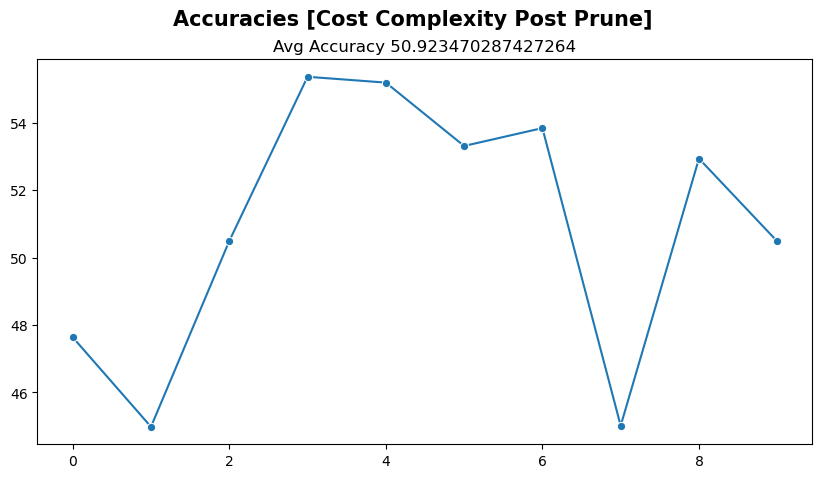

In [126]:
avg_accuracy = np.mean(accuracies)
plt.figure(figsize=(10, 5))
sns.lineplot(accuracies, marker='o')
plt.suptitle('Accuracies [Cost Complexity Post Prune]', size=15, weight='bold')
plt.title(f'Avg Accuracy {avg_accuracy}')
plt.show()

In [127]:
best_alpha = np.array(alphas)[np.argmax(accuracies)]
best_alpha

0.04000000000000001

In [128]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='entropy')
data = cross_validation(X, Y, model, k=5, pruning='ccp', alpha=best_alpha)
model.print_tree()

 leaf: class 1 | {1: 202, 0: 222} | level: 0


In [129]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
data = cross_validation(X, Y, model, k=5, pruning='ccp', alpha=best_alpha)
model.print_tree()

 Feature 6: <= 1 |  {1: 189, 0: 235} | info_gain: 0.03853286707742121 | level: 0
   leaf: class 1 | {1: 62, 0: 24} | level: 1
   leaf: class 1 | {1: 127, 0: 211} | level: 1


the alpha really cuts down all the subtree, leaving us with only one leave, there's a chance lower alpha cut down not the whole subtrees

## `Scenario 3:` Post Pruning [REP]

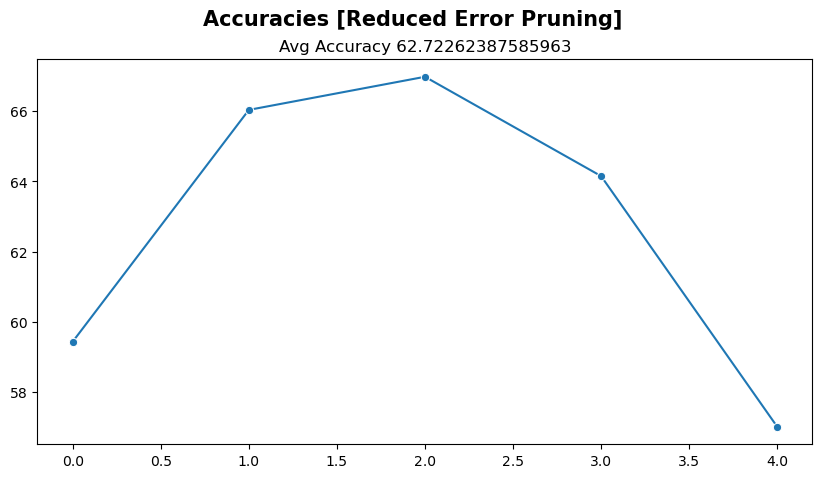

In [130]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
data = cross_validation(X, Y, model, k=5, pruning='rep')
avg_accuracy = np.mean(data['accuracies'])

plt.figure(figsize=(10, 5))
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracies [Reduced Error Pruning]', size=15, weight='bold')
plt.title(f'Avg Accuracy {avg_accuracy}')
plt.show()

In [131]:
model.print_tree()

 Feature 5: <= 2973 |  {0: 232, 1: 192} | info_gain: 0.060477875735555964 | level: 0
   Feature 5: <= 2058 |  {0: 40, 1: 96} | info_gain: 0.02065151656847153 | level: 1
     Feature 1: <= 0 |  {1: 23, 0: 2} | info_gain: 0.02275555555555557 | level: 2
       Feature 2: <= 24 |  {1: 7, 0: 2} | info_gain: 0.04938271604938271 | level: 3
         Feature 2: <= 21 |  {1: 4, 0: 2} | info_gain: 0.17777777777777787 | level: 4
           Feature 2: <= 18 |  {1: 4, 0: 1} | info_gain: 0.11999999999999983 | level: 5
             Feature 0: <= 1 |  {1: 1, 0: 1} | info_gain: 0.5 | level: 6
               leaf: class 0 | {0: 1} | level: 7
               leaf: class 1 | {1: 1} | level: 7
             leaf: class 1 | {1: 3} | level: 6
           leaf: class 0 | {0: 1} | level: 5
         leaf: class 1 | {1: 3} | level: 4
       leaf: class 1 | {1: 16} | level: 3
     Feature 5: <= 2290 |  {0: 38, 1: 73} | info_gain: 0.027543520893615114 | level: 2
       Feature 6: <= 4 |  {0: 14, 1: 11} | info_gain: 0.

In [132]:
feature_importance = pd.DataFrame([model.feature_importance[0], model.feature_importance[1], df_clean.columns.tolist()[:-1]]).T
feature_importance.columns = ['info_gain', 'count', 'feature_name']
feature_importance

,info_gain,count,feature_name
0,0.780466,3.0,Department
1,1.99468,9.0,Gender
2,7.857587,34.0,Age
3,2.460642,12.0,EnvironmentSatisfaction
4,1.163311,8.0,JobSatisfaction
5,4.810427,34.0,MonthlyIncome
6,1.755667,13.0,YearsAtCompany


REP has the highest accuracy out of all and same feature importance

## `Conclusion` 👷‍♂️✅

0. Slight tendency `gini` perform batter than entropy
1. **Minimum Limitations**: The `Tree` Becomes Really `complex` and `overfit` the testing set, reason: no stopping criteria, one leave is for one class with most of them has small samples (range 1 - 5)
2. **Pre Pruning**: max depth, min sample and all don't really effect, but features do, not specifief features give better accuracy
3. **CCP**: makes the tree become very simple, and under fit, reason: the subtrees mostly has higher cost rather than the information, so many are pruned   
4. **REP**: gives best accuracy because it uses testing set to update the subtree into leave 

In [133]:
class TreeVisualization:
    def __init__(self, tree, data_df, target_col, feature_names):
        self.tree = tree
        self.data_df = data_df
        self.target_col = target_col
        self.feature_names = feature_names
        self.mode = tree.mode
        self.node_cache = {}
        self.palette = self._create_color_palette()
        self._cache_nodes(tree.root)

    def entropy(self, y):
        classes = np.unique(y)
        entropy = 0
        for cls in classes:
            p_cls = len(y[y==cls]) / len(y)
            entropy += -p_cls * np.log(p_cls)
        return entropy
    
    def gini(self, y):
        classes = np.unique(y)
        gini = 0
        for cls in classes:
            p_cls = len(y[y==cls]) / len(y)
            gini += p_cls ** 2
        return 1-gini
    
    def _create_color_palette(self):
        classes = np.unique(self.data_df[self.target_col])
        return dict(zip(classes, sns.color_palette("Set2", n_colors=len(classes))))

    def _calculate_impurity(self, y):
        return self.gini(y) if self.mode == 'gini' else self.entropy(y)
    
    def _cache_nodes(self, root):
        queue = deque([root])
        while queue:
            node = queue.popleft()
            self.node_cache[id(node)] = node
            if getattr(node,'left', None):
                queue.extend([node.left, node.right])

    def get_prediction_path(self, x):
        path, decisions = [], []
        node = self.tree.root
        while node.value is None:
            path.append(node)
            feature_val = x[node.feature_index]
            val_str = f"{feature_val:.2f}" if isinstance(feature_val, (int, float)) else str(feature_val)
            thresh_str = f"{node.threshold:.2f}" if isinstance(node.threshold, (int, float)) else str(node.threshold)
            op = "≤" if feature_val <= node.threshold else ">"
            decisions.append(f"Step {len(path)}: {self.feature_names[node.feature_index]} = {val_str} {op} {thresh_str}")
            node = node.left if feature_val <= node.threshold else node.right
        path.append(node)
        decisions.append(f"Final: Class {node.value}")
        return path, decisions
    
    def plot_prediction_path(self, x=None, step=None, fig=None, ax=None):
        fig = fig or plt.figure(figsize=(12,8))
        ax = ax or fig.add_subplot(111)
        ax.clear(); ax.set_axis_off()
    
        node_width, node_height, level_height = 0.15, 0.1, 0.2
        node_boxes, path_ids = {}, {}
    
        def get_node_positions(node, level=0, x_pos=0.5):
            pos = {id(node):(x_pos, 1 - level*level_height)}
            if getattr(node, 'left', None):
                spacing = 0.25/(level+1)
                pos.update(get_node_positions(node.left, level+1, x_pos-spacing))
                pos.update(get_node_positions(node.right, level+1, x_pos+spacing))
            return pos
    
        node_positions = get_node_positions(self.tree.root)
        if x is not None:
            prediction_path, decisions = self.get_prediction_path(x)
            if step is not None:
                prediction_path = prediction_path[:step]
            path_ids = {id(n) for n in prediction_path}
    
        for node_id, (x_pos, y) in node_positions.items():
            node = self.node_cache[node_id]
            node_boxes[node_id] = [x_pos - node_width/2, y - node_height/2, node_width, node_height]
            node_ax = fig.add_axes([x_pos - node_width/2, y - node_height/2, node_width, node_height])
            if node.value is not None:
                self._draw_leaf_node(node_ax, node, node_id in path_ids)
            else:
                self._draw_decision_node(node_ax, node, node_id in path_ids)
    
        self._draw_connections(node_positions, node_boxes, path_ids, ax)
    
        legend_elements = [
            Patch(facecolor=self.palette[cls], alpha=0.3, label=cls)
            for cls in sorted(self.data_df[self.target_col].unique())
        ]
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1.2), title="Classes")
    
        if x is not None:
            title = (f"Decision Tree Path - Step {step} of {len(decisions)}"
                     if step is not None else f"Complete Decision Path\nFinal Prediction: Class {self.tree.predict([x])[0]}")
        else:
            title = f"Complete Decision Tree Visualization\nImpurity Measure: {self.mode.capitalize()}"
        fig.suptitle(title, fontsize=25, y=1.2)
        return fig, ax
    def _draw_leaf_node(self, ax, node, is_active):
        ax.axis('off')
        color, width = ('red', 2) if is_active else ('black', 1)
        dist = Counter(node.sample)
        txt = f'Class {node.value}\n' + '\n'.join(f"Class {k}: {v}" for k, v in dist.items())
        txt += f'\n{"Gini" if self.mode=="gini" else "Entropy"}: {self._calculate_impurity(node.sample):.3f}'
        bg_color = self.palette[max(dist, key=dist.get)]
        ax.text(0.5, 0.5, txt, ha='center', va='center', bbox=dict(boxstyle='round', fc=(*bg_color, 0.3), ec=color, linewidth=width), fontsize=8)
    
    def _draw_decision_node(self, ax, node, is_active):
        color, width = ('red', 2) if is_active else ('black', 1)
        sns.histplot(data=self.data_df, x=self.feature_names[node.feature_index],
                     hue=self.target_col, palette=self.palette, multiple='stack', ax=ax)
        ax.set(xlabel='', ylabel='')
        ax.axvline(node.threshold, color=color, linestyle='--', linewidth=width)
        if ax.get_legend(): ax.get_legend().remove()
        dist = Counter(node.sample)
        thresh_str = f"{node.threshold:.2f}" if isinstance(node.threshold, (int, float)) else str(node.threshold)
        title = (f'{self.feature_names[node.feature_index]} <= {thresh_str} \n' +
                 ' '.join(f"Class {k}: {v}" for k, v in dist.items()) +
                 f'\n{"Gini" if self.mode=="gini" else "Entropy"}: {self._calculate_impurity(node.sample):.3f}')
        ax.set_title(title, fontsize=8, color=color )
    
    def _draw_connections(self, positions, boxes, path_ids, main_ax):
        for node_id, _ in positions.items():
            node = self.node_cache[node_id]
            if getattr(node, 'left', None):
                for child in [node.left, node.right]:
                    is_active = node_id in path_ids and id(child) in path_ids
                    self._draw_connection(node, child, boxes, is_active, main_ax)
    
    def _draw_connection(self, parent, child, boxes, is_active, main_ax):
        color, width = ('red', 2) if is_active else ('black', 1)
        p_box, c_box = boxes[id(parent)], boxes[id(child)]
        con = ConnectionPatch(xyA=(p_box[0] + p_box[2]/2, p_box[1]),
                              xyB=(c_box[0] + c_box[2]/2, c_box[1] + c_box[3] ),
                              coordsA='figure fraction', coordsB='figure fraction',
                              axesA=main_ax, axesB=main_ax,
                              arrowstyle="->", color=color, linewidth=width
                              )
        main_ax.add_artist(con)


(<Figure size 1200x800 with 22 Axes>, <Axes: >)

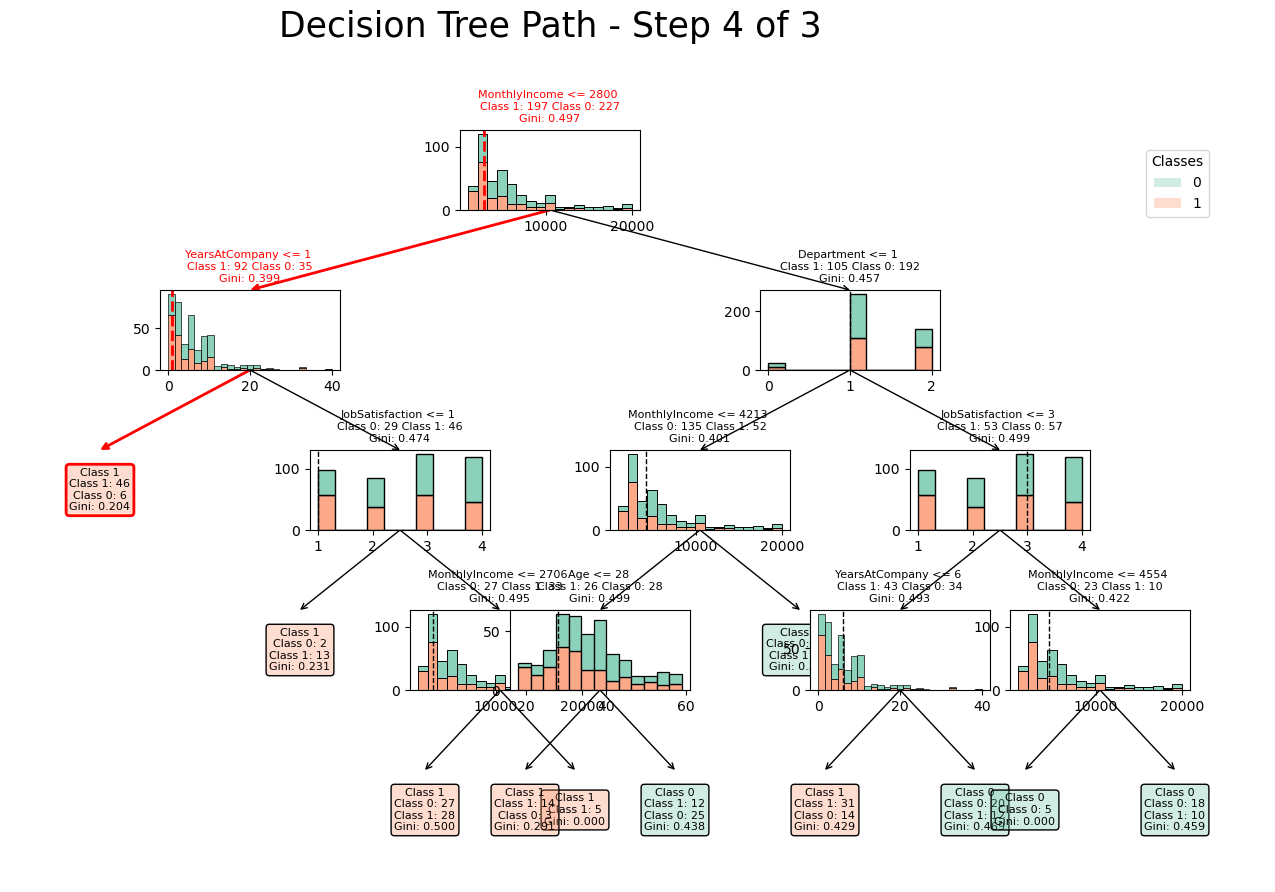

In [134]:
feature_names = ['Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany']
target_col = 'Attrition'

X = df_clean[feature_names].values
Y = df_clean[target_col].values

model = DecisionTreeClassifier(max_depth=3, min_sample_split=2, min_sample_leaf=5,  mode='gini')
data = cross_validation(X, Y, model, k=5, pruning=False, alpha=0.0)

data_df = pd.DataFrame(data['X_train'], columns=feature_names)
data_df[target_col] = data['y_train'].flatten()

viz = TreeVisualization(model, data_df=data_df, target_col=target_col, feature_names=feature_names )
viz.plot_prediction_path(data['X_train'][0], step=4)

In [135]:
data['X_train'][0]

array([   1,    0,   22,    3,    1, 2398,    1], dtype=int64)

In [136]:
def classification_report(y_pred, y_test):
    accuracy = np.mean(y_pred == y_test)
    classes = np.unique(y_test)
    report_data = []

    for cls in classes:
        # predicted as right is right
        TP = np.sum((y_pred == cls) & (y_test == cls))
        # predicted as right is actually not
        FP = np.sum((y_pred == cls) & (y_test != cls))
        # predicted as other class actually right
        FN = np.sum((y_pred != cls) & (y_test != cls))

        # ratio of the right among the predicted right (ex: 80% right 20% others are predicted right but actualy not)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0 
        # ratio of the right among the predicted correctly (ex: 70% right 30% others are predicted as other class but actualy right)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1_score = 2 * (precision * recall)
        data = [cls, precision, recall, f1_score]
        report_data.append(data)
    
    report_df = pd.DataFrame(report_data, columns=['class', 'precision', 'recall', 'f1 score'])
    report_df['accuracy'] = ['-', accuracy]
    return report_df

In [137]:
y_pred_test = model.predict(data['X_test'])
y_pred_train = model.predict(data['X_train'])
pred = np.concatenate([y_pred_test, y_pred_train])
indices = np.concatenate([data['test_indices'], data['train_indices']]) 
df_clean.loc[indices, 'pred'] = pred 
df_clean.head()

,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany,Attrition,pred
0,1,0,31,2,1,4306,13,0,0.0
1,0,1,51,3,2,14026,33,0,0.0
2,1,1,35,3,3,4249,9,0,0.0
3,1,0,34,3,1,4381,6,0,0.0
4,2,1,32,4,4,9204,4,0,0.0


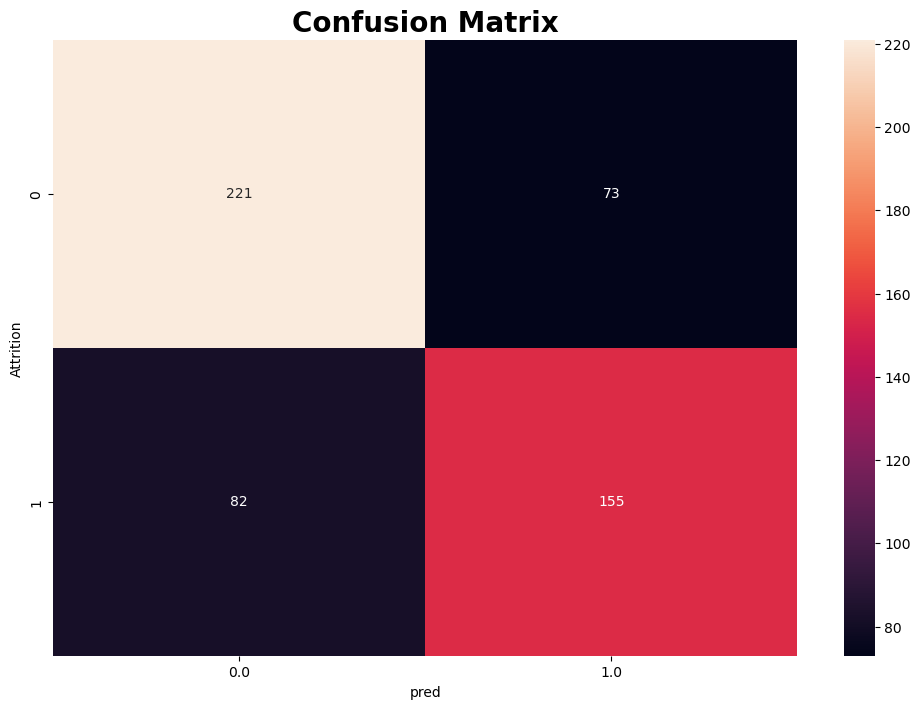

In [138]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(df_clean['Attrition'], df_clean['pred']), annot=True, fmt='d')
plt.title('Confusion Matrix', size=20, weight='bold')
plt.show()

In [139]:
report_df = classification_report(df_clean['pred'], df_clean['Attrition'])
report_df

,class,precision,recall,f1 score,accuracy
0,0,0.729373,0.587766,0.857401,-
1,1,0.679825,0.412234,0.560494,0.708098


`class 0` is mostly `predicted` as its own, while `class 1` often `misscalssified` even almost even

<div style="background-color:red; color:white; font-family:'Poppins'; font-size:40px; border-radius:10px; padding:30px; text-align:center;">4 | TkInter App </div>
This is the product of GUI with best model and parameter (download the notebook to try)

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\arsya\anaconda3\envs\lks_env\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\arsya\AppData\Local\Temp\ipykernel_16532\1532071009.py", line 123, in predict_and_plot
    self.new_instance = np.array([int(x) for x in self.new_input])
  File "C:\Users\arsya\AppData\Local\Temp\ipykernel_16532\1532071009.py", line 123, in <listcomp>
    self.new_instance = np.array([int(x) for x in self.new_input])
ValueError: invalid literal for int() with base 10: ''


5
12
6
1
5
12
6
1


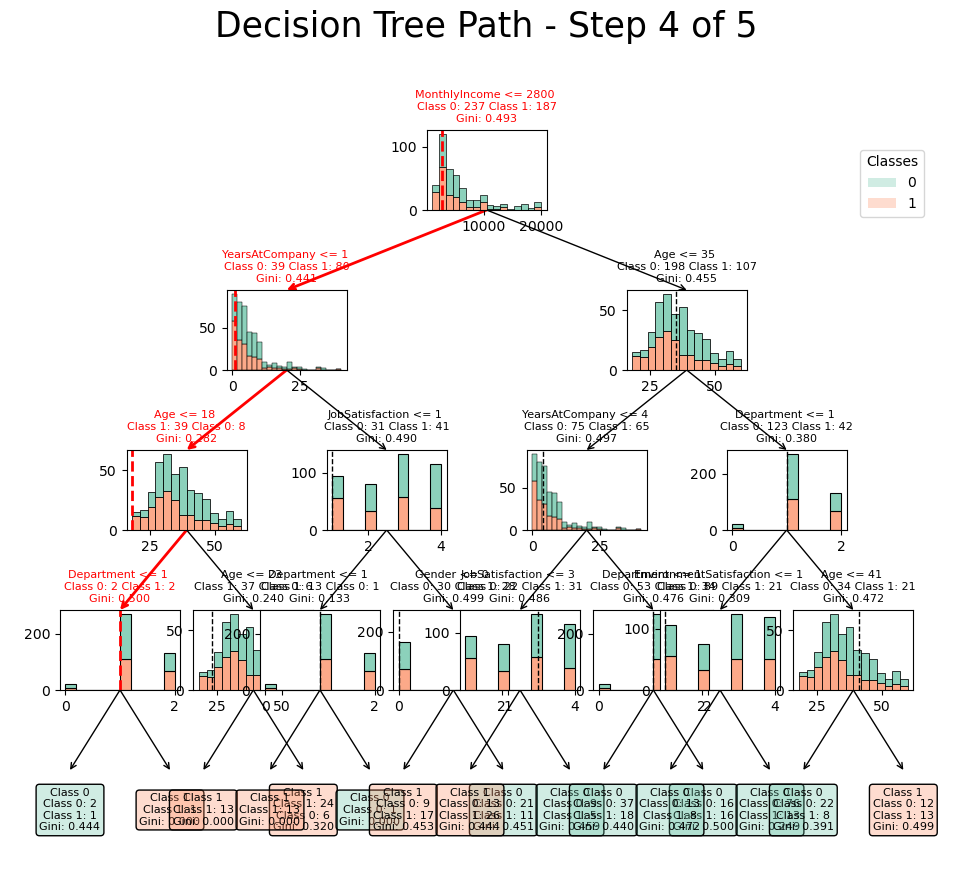

In [142]:
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class TkinterApp:
    def __init__(self, root):
        self.root = root
        self.root.attributes('-fullscreen', True)
        self.root.title("Employer Attrition Prediction App")

        self.tab_control = ttk.Notebook(root)
        self.predict_tab = ttk.Frame(self.tab_control, padding="30")
        self.history_tab = ttk.Frame(self.tab_control, padding="30")
        self.setting_tab = ttk.Frame(self.tab_control, padding="30")

        ttk.Style().configure('TNotebook.tab', font=('Poppins', 20), padding="30 10 30 10")
        self.tab_control.add(self.predict_tab, text="Predict Tab")
        self.tab_control.add(self.history_tab, text="History Tab")
        self.tab_control.add(self.setting_tab, text="Setting Tab")
        self.tab_control.pack(anchor='w', fill='x')

        self.init_predict_tab()
        self.init_history_tab()
        self.init_setting_tab()

    # Department	Gender	Age	EnvironmentSatisfaction	JobSatisfaction	MonthlyIncome	YearsAtCompany
    def init_predict_tab(self):
        ttk.Label(self.predict_tab, text="Reward Employee App", font=('Poppins', 32)).grid(column=0, row=0,sticky='w')
        ttk.Label(self.predict_tab, text="Input your type of emplyee and make it consideration", font=('Poppins light', 15)).grid(column=0, row=1, sticky='w')
        
        self.frame_input = ttk.Frame(self.predict_tab)
        self.frame_input.grid(column=0, row=2, sticky='w')

        ttk.Label(self.frame_input, text="Deparment", font=('Poppins', 13)).grid(column=0, row=0, sticky='w')
        self.department_select = ttk.Combobox(self.frame_input, value=(['Research & Development', 'Sales', 'Human Resources']) , font=('Poppins', 14))
        self.department_select.grid(column=0, row=1)
        ttk.Label(self.frame_input, text="Deparment", font=('Poppins', 10)).grid(column=0, row=2, sticky='w')

        ttk.Label(self.frame_input, text="Gender", font=('Poppins', 13)).grid(column=1, row=0, sticky='w')
        self.gender_select = ttk.Combobox(self.frame_input, value=(['Male', 'Female']), font=('Poppins', 14))
        self.gender_select.grid(column=1, row=1)
        ttk.Label(self.frame_input, text="Male or Female", font=('Poppins', 10)).grid(column=1, row=2, sticky='w')

        ttk.Label(self.frame_input, text="Age", font=('Poppins', 13)).grid(column=2, row=0, sticky='w')
        self.age_enty = ttk.Entry(self.frame_input, font=('Poppins', 14))
        self.age_enty.grid(column=2, row=1)
        ttk.Label(self.frame_input, text="Integer", font=('Poppins', 10)).grid(column=2, row=2, sticky='w')

        ttk.Label(self.frame_input, text="Job Satisfaction", font=('Poppins', 13)).grid(column=3, row=0, sticky='w')
        self.job_satisfaction_entry = ttk.Combobox(self.frame_input, value=([1,2,3,4]), font=('Poppins', 14))
        self.job_satisfaction_entry.grid(column=3, row=1)
        ttk.Label(self.frame_input, text="Range 1-4 Numerical", font=('Poppins', 10)).grid(column=3, row=2, sticky='w')

        ttk.Label(self.frame_input, text="Environment Satisfaction", font=('Poppins', 13)).grid(column=4, row=0, sticky='w')
        self.environment_satisfaction_entry = ttk.Combobox(self.frame_input, value=([1,2,3,4]), font=('Poppins', 14))
        self.environment_satisfaction_entry.grid(column=4, row=1)
        ttk.Label(self.frame_input, text="Range 1-4 Numerical", font=('Poppins', 10)).grid(column=4, row=2, sticky='w')

        ttk.Label(self.frame_input, text="MonthlyIncome", font=('Poppins', 13)).grid(column=5, row=0, sticky='w')
        self.monthly_income_entry = ttk.Entry(self.frame_input, font=('Poppins', 14))
        self.monthly_income_entry.grid(column=5, row=1)
        ttk.Label(self.frame_input, text="in usd", font=('Poppins', 10)).grid(column=5, row=2, sticky='w')

        ttk.Label(self.frame_input, text="YearsAtCompany", font=('Poppins', 13)).grid(column=6, row=0, sticky='w')
        self.years_at_company_entry = ttk.Entry(self.frame_input, font=('Poppins', 14))
        self.years_at_company_entry.grid(column=6, row=1)
        ttk.Label(self.frame_input, text="Integer (total years)", font=('Poppins', 10)).grid(column=6, row=2, sticky='w')

        ttk.Button(self.frame_input, text="Train Model", command=self.predict_and_plot).grid(column=0, row=3, sticky='w')

        self.frame_fig = ttk.Frame(self.predict_tab)
        self.frame_fig.grid(column=0, row=4, sticky='w')
        
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.canvas = FigureCanvasTkAgg(self.fig, self.frame_fig)
        self.canvas.draw()
        self.canvas.get_tk_widget().grid(column=0, row=1, sticky='w')
        
        self.frame_result = ttk.Frame(self.frame_fig)
        self.frame_result.grid(column=1, row=1, sticky='w', padx=(20, 0))
        ttk.Label(self.frame_fig, text="Prediction Result", font=('Poppins', 32)).grid(column=1, row=0,sticky='w')
        
        self.step = tk.Scale(self.frame_fig, from_=0, to=10, orient='horizontal', 
                               command=self.update_plot, 
                               length=400, tickinterval=1, resolution=1)
                               
        self.step.set(0)  # Set initial value to 0
        self.step.grid(column=0, row=0)

    def update_plot(self, value):
        self.fig.clf()
        self.ax = self.fig.add_subplot(111)

        path, decisions = self.viz.get_prediction_path(self.new_instance)
        max_steps = len(decisions)
        self.step.config(to=max_steps)

        current_step = int(self.step.get())
        if current_step > max_steps:
            current_step = max_steps
            self.step.set(max_steps)


        self.viz.plot_prediction_path(x=self.new_instance, step=current_step, fig=self.fig, ax=self.ax)
        self.canvas.draw()

    def predict_and_plot(self):
        # try:
        self.fig.clf()
        departments = {'Sales': 0, 'Research & Development': 1, 'Human Resources': 0}
        gender = {'Female': 0, 'Male': 1}
        
        self.new_input = np.array(
            [departments.get(self.department_select.get()), 
            gender.get(self.gender_select.get()), 
            self.age_enty.get(), 
            self.job_satisfaction_entry.get(), 
            self.environment_satisfaction_entry.get(), 
            self.monthly_income_entry.get(), 
            self.years_at_company_entry.get()
            ]
        )
        self.new_instance = np.array([int(x) for x in self.new_input])
        
        feature_names = ['Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany']
        target_col = 'Attrition'

        X = df_clean[feature_names].values
        Y = df_clean[target_col].values
        self.model = DecisionTreeClassifier(max_depth=int(self.max_depth_entry.get()), min_sample_split=int(self.min_sample_split_entry.get()), min_sample_leaf=int(self.min_sample_leaf_entry.get()),  mode=self.mode_entry.get())
        
        # self.model = DecisionTreeClassifier(max_depth=self.max_depth_entry.get(), min_sample_split=self.min_sample_split_entry.get(), min_sample_leaf=self.min_sample_leaf_entry.get(),  mode=self.mode_entry.get())
        self.data = cross_validation(X, Y, self.model, k=5, pruning=self.post_pruning_select.get(), alpha=best_alpha)

        predict = model.make_predictions(self.new_instance, model.root)
        count_prediction = model.get_leaf_info(self.new_instance)[1]
        ratio_prediction = {k: round(v / sum(count_prediction.values()), 2) for k, v in count_prediction.items()}

        data_df = pd.DataFrame(self.data['X_train'], columns=feature_names)
        data_df[target_col] = self.data['y_train'].flatten()

        self.viz = TreeVisualization(self.model, data_df=data_df, target_col=target_col, feature_names=feature_names )
        self.viz.plot_prediction_path(self.new_instance, step=self.step.get(), fig=self.fig, ax=self.ax)

        # Redraw the canvas
        self.canvas.draw()
        
        new_row = {
            'Label Predict': [predict],
            'Predict Detail': [ratio_prediction],
            'Department': [departments.get(self.department_select.get())],
            'Gender': [gender.get(self.gender_select.get())],
            'Age': [self.age_enty.get()],
            'EnvironmentSatisfaction': [self.environment_satisfaction_entry.get()],
            'JobSatisfaction': [self.job_satisfaction_entry.get()],
            'MonthlyIncome': [self.monthly_income_entry.get()],
            'YearsAtCompany': [self.years_at_company_entry.get()],
            'Max_depth': [self.max_depth_entry.get()],
            'Min_sample_split': [self.min_sample_split_entry.get()],
            'Min_sample_leaf': [self.min_sample_leaf_entry.get()],
            'Mode': [self.mode_entry.get()],
            'Post Pruning': [self.post_pruning_select.get()],
        }

        row=1
        col=0 
        for column, value in new_row.items():
            label_title = column.replace('_', ' ').title()
            label_value = value[0]
            ttk.Label(self.frame_result, text=label_title, font=('Poppins light', 15)).grid(column=col, row=row, sticky='w', padx=(0, 30))
            ttk.Label(self.frame_result, text=label_value, font=('Poppins medium', 20)).grid(column=col, row=row+1, sticky='w', padx=(0, 30))
            col += 1
            if col == 2:
                col = 0
                row += 2
 
    def init_history_tab(self):
        ttk.Label(self.history_tab, text="History and Compare", font=('Poppins', 32)).grid(column=0, row=0,sticky='w')
        ttk.Label(self.history_tab, text="Check History and compare the performance model", font=('Poppins light', 15)).grid(column=0, row=1, sticky='w')

    def init_setting_tab(self):
        ttk.Label(self.setting_tab, text="Adjust your best setting", font=('Poppins', 32)).grid(column=0, row=0,sticky='w')
        ttk.Label(self.setting_tab, text="by default, model setting is in best performance", font=('Poppins light', 15)).grid(column=0, row=1, sticky='w')
        
        self.frame_setting = ttk.Frame(self.setting_tab)
        self.frame_setting.grid(column=0, row=0)

        ttk.Label(self.frame_setting, text="Post - Pruning", font=('Poppins', 25)).grid(column=0, row=0, sticky='w')
        ttk.Label(self.frame_setting, text="Method Post Pruning", font=('Poppins', 15)).grid(column=0, row=0, sticky='w')
        self.post_pruning_select_var = tk.StringVar(value='rep')
        self.post_pruning_select = ttk.Combobox(self.frame_setting, value=([False, 'ccp', 'rep']), textvariable=self.post_pruning_select_var, font=('Poppins', 18))
        self.post_pruning_select.grid(column=0, row=1)
        ttk.Label(self.frame_setting, text="Select post pruning method", font=('Poppins', 10)).grid(column=0, row=2, sticky='w')

        ttk.Label(self.frame_setting, text="Pre - Pruning", font=('Poppins', 25)).grid(column=0, row=0, sticky='w')
        ttk.Label(self.frame_setting, text="Min Sample Split", font=('Poppins', 15)).grid(column=2, row=0, sticky='w')
        self.min_sample_split_entry_var = tk.IntVar(value=2)
        self.min_sample_split_entry = ttk.Entry(self.frame_setting, font=('Poppins', 18), textvariable=self.min_sample_split_entry_var)
        self.min_sample_split_entry.grid(column=2, row=1)
        ttk.Label(self.frame_setting, text="Integer", font=('Poppins', 10)).grid(column=2, row=2, sticky='w')

        ttk.Label(self.frame_setting, text="Min Sample Leaf", font=('Poppins', 15)).grid(column=3, row=0, sticky='w')
        self.min_sample_leaf_entry_var = tk.IntVar(value=1)
        self.min_sample_leaf_entry = ttk.Entry(self.frame_setting, font=('Poppins', 18), textvariable=self.min_sample_leaf_entry_var)
        self.min_sample_leaf_entry.grid(column=3, row=1)
        ttk.Label(self.frame_setting, text="Range 1-4 Numerical", font=('Poppins', 10)).grid(column=3, row=2, sticky='w')

        ttk.Label(self.frame_setting, text="Max Depth", font=('Poppins', 15)).grid(column=4, row=0, sticky='w')
        self.max_depth_entry_var = tk.IntVar(value=3)
        self.max_depth_entry = ttk.Entry(self.frame_setting, font=('Poppins', 18), textvariable=self.max_depth_entry_var)
        self.max_depth_entry.grid(column=4, row=1)
        ttk.Label(self.frame_setting, text="Range 1-4 Numerical", font=('Poppins', 10)).grid(column=4, row=2, sticky='w')

        ttk.Label(self.frame_setting, text="Mode", font=('Poppins', 15)).grid(column=5, row=0, sticky='w')
        self.mode_entry_var = tk.StringVar(value='gini')
        self.mode_entry = ttk.Combobox(self.frame_setting, value=(['gini', 'entropy']) , textvariable=self.mode_entry_var, font=('Poppins', 18))
        self.mode_entry.grid(column=5, row=1)
        ttk.Label(self.frame_setting, text="in usd", font=('Poppins', 10)).grid(column=5, row=2, sticky='w')
       

if __name__ == "__main__":
    root = tk.Tk()
    app = TkinterApp(root)
    root.mainloop()                                                                                 
